# Análisis de datos EcoBici 2021
El servicio de bicicletas públicas de la ciudad empezó en 2010 y ha ido evolucionando a pasos agigantados. El dataframe con el que trabajaré es el primero que no contiene datos personales de los usuarios, que pasaron a ser identificados únicamente con un id. Los datos se pueden encontrar en la __[página web que proporciona datos de la ciudad](https://data.buenosaires.gob.ar/dataset/bicicletas-publicas)__. Para ver algunos ejemplos de esta información que dejó de ser proporcionada se puede visitar __[mi análisis del año 2017.](https://github.com/CreamBBQ/EcoBici-2017)__  El dataset original fue modificado a mi conveniencia, creando nuevas variables y desechando algunas inútiles a los fines de este análisis. Las modificaciones antes descritas se pueden consultar en el archivo "clean.R", disponible en este repositorio. Cualquier error, anotación o punto de mejora puedes comunicarte conmigo a @CreamBBQ en twitter o jgmd1306@gmail.com vía correo electrónico.


In [ ]:
rm(list = ls())
setwd("/home/creambbq/code/bikes/archivos")
library(tidyverse)
library(sf)
library(ggthemes)
library(RColorBrewer)
load("dataClean.RData")
colors <- colorRampPalette(brewer.pal(8, "Set3"))(15)
bairesMap <- st_read("http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson",
                     stringsAsFactors = FALSE)
bairesMap$COMUNA <- as.integer(bairesMap$COMUNA)
bairesMap$COMUNA <- as.factor(bairesMap$COMUNA)
bairesMap <- bairesMap %>% mutate(km2 = as.numeric(AREA)/1000000)
subte <- st_read("http://cdn.buenosaires.gob.ar/datosabiertos/datasets/subte-estaciones/subte_estaciones.geojson")
stations <- ecoBiciData %>% group_by(nombre_estacion_origen,lat_estacion_origen,long_estacion_origen) %>% 
summarise() %>%  ungroup()

En la ciudad hay disponibles, al día de hoy, 274 estaciones de EcoBici. Veamos como están distribuidas a lo largo de la ciudad. 

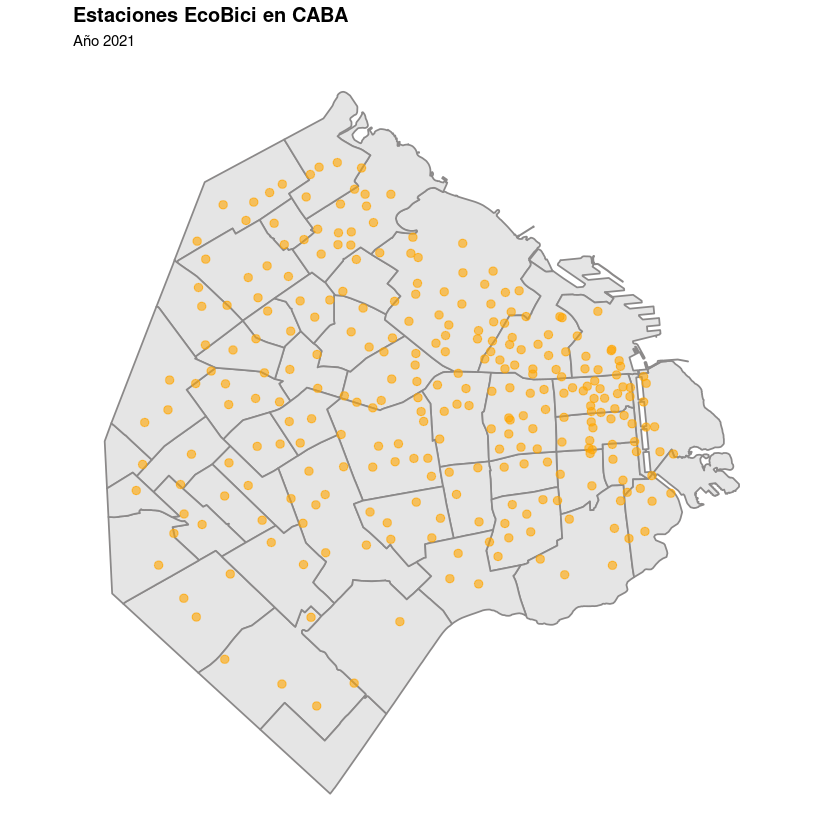

In [2]:
ggplot() + 
  geom_sf(data = bairesMap, color = "snow4") +
  geom_point(data = stations, aes(x = long_estacion_origen, y = lat_estacion_origen),
             color = "orange", size = 2, alpha = 0.6) +
  labs(title = "Estaciones EcoBici en CABA", 
       subtitle = "Año 2021") +
  theme_map() +
  theme(plot.title = element_text(size = 12, face = "bold"))

Más interesante, veamos como están distribuidas las mismas estaciones distinguiendo por las comunas capitalinas.

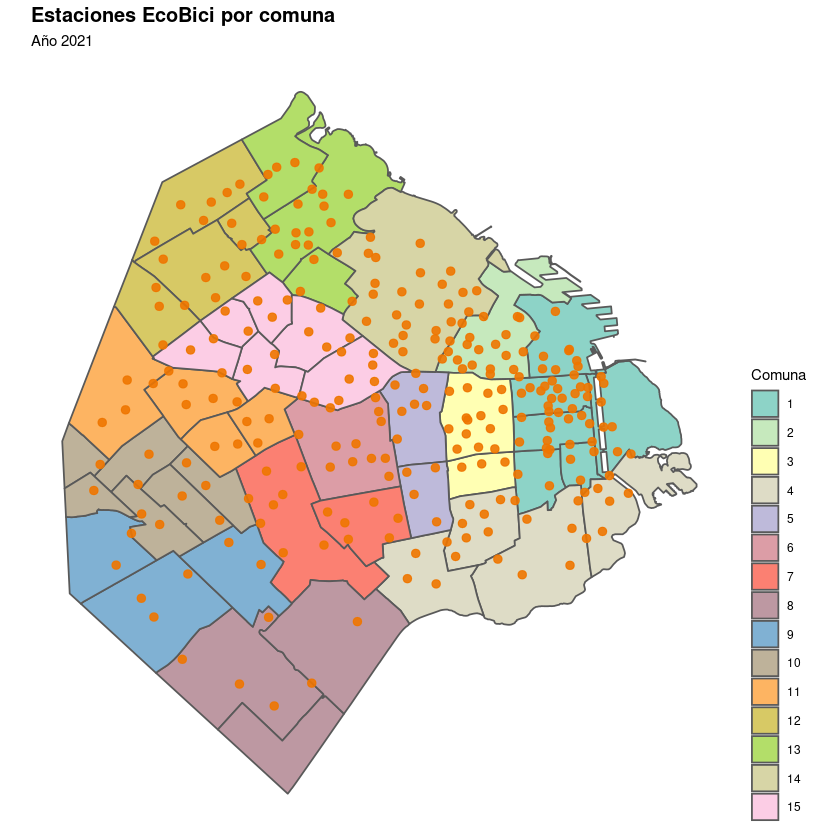

In [3]:
spaceStations <- stations %>% st_as_sf(coords = c("long_estacion_origen", "lat_estacion_origen"), crs = 4326)
ggplot() +
  geom_sf(data = bairesMap, aes(fill = COMUNA)) + 
  geom_sf(data = spaceStations, color = "darkorange2", size = 2, alpha = 0.9) +
  labs(title = "Estaciones EcoBici por comuna",
       subtitle = "Año 2021",
       fill = "Comuna") +
  theme_map() +
  theme(plot.title = element_text(size = 12, face = "bold"),
        legend.position = "right") +
  scale_fill_manual(values = colors)

Según los informes oficiales la red de bicicletas públicas ha sido de gran ayuda para descongestionar las líneas de SUBTE y darle acceso al servicio a personas que antes no podían. Por eso es interesante comparar la ubicación geográfica de las estaciones EcoBici con las líneas de SUBTE.

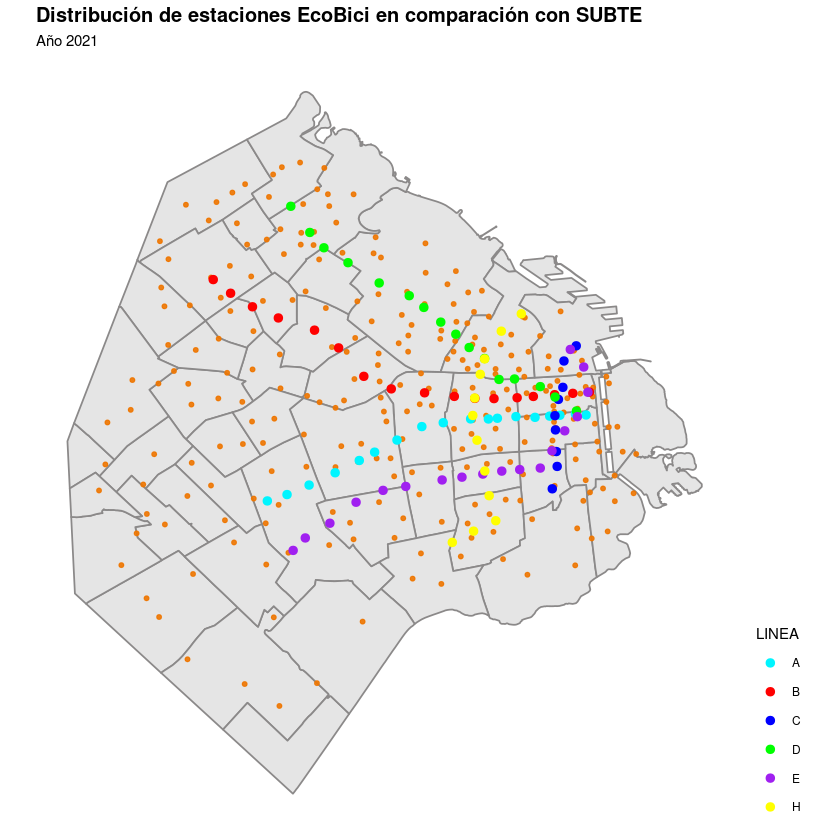

In [4]:
ggplot() +
  geom_sf(data = bairesMap, color = "snow4") + 
  geom_sf(data = spaceStations, color = "darkorange2", size = 1, alpha = 0.9) +
  geom_sf(data = subte, aes(color = LINEA), size = 2) +
  labs(title = "Distribución de estaciones EcoBici en comparación con SUBTE",
       subtitle = "Año 2021") +
  theme_map() +
  theme(plot.title = element_text(size = 12, face = "bold"),
        legend.position = "right") +
  scale_color_manual(values = c("turquoise1", "red", "blue", "green", "purple", "yellow"))

Dejando de lado los mapas, es interesante ver como cambian la hora de extracción dependiendo si es fin de semana o no. Además, se puede observar como el servicio es utilizado mucho más en los días de semana, lo que sugiere que el servicio es más utilizado como medio de transporte laboral y/o estudiantil que ocioso. 

`summarise()` has grouped output by 'fecha', 'fin_de_semana'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'fin_de_semana'. You can override using the
`.groups` argument.


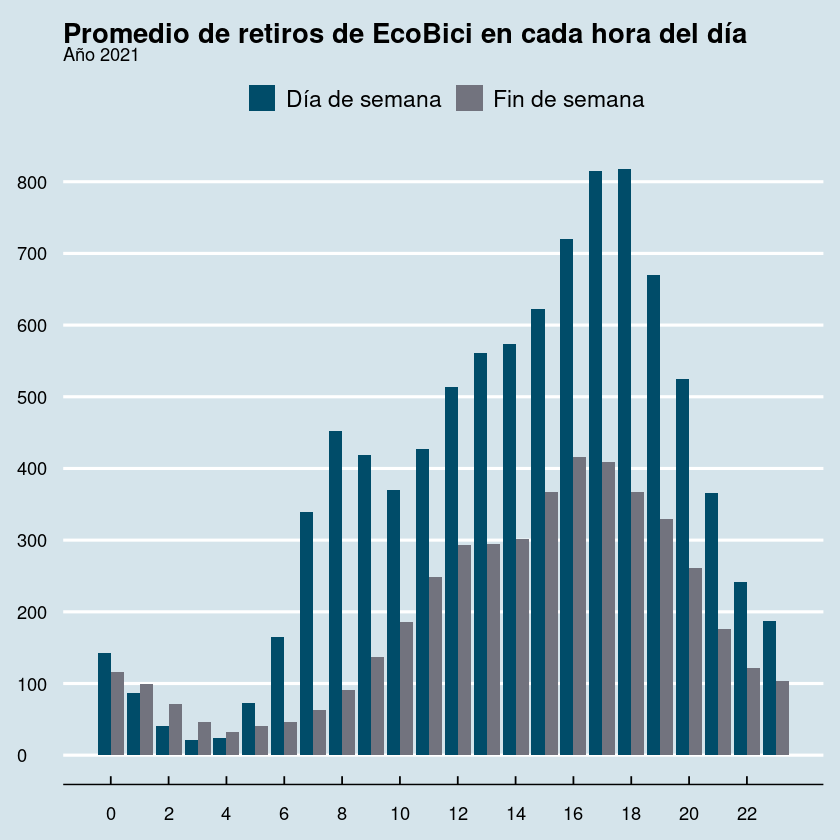

In [5]:
ecoBiciData$fecha <- as.Date(ecoBiciData$fecha_origen_recorrido, tz = "America/Argentina/Buenos_Aires" ) 
ecoBiciData %>% group_by(fecha, fin_de_semana, hora) %>% 
  summarise(total = n()) %>%  group_by(fin_de_semana, hora) %>% 
  summarise(media = mean(total)) %>% 
  ggplot(aes(x = hora, y = media, fill = fin_de_semana)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Promedio de retiros de EcoBici en cada hora del día",
       subtitle = "Año 2021") + 
  scale_fill_manual(values = c("#004c69","#72737e")) +
  scale_x_continuous(breaks = seq(0, 23, 2)) +
  scale_y_continuous(breaks = seq(0, 850, 100)) + 
  theme_economist() + 
  theme(legend.title = element_blank(), 
        axis.title = element_blank())

Los minutos de viaje promedio, en cambio, no poseen cambios significativos usando la misma distinción.

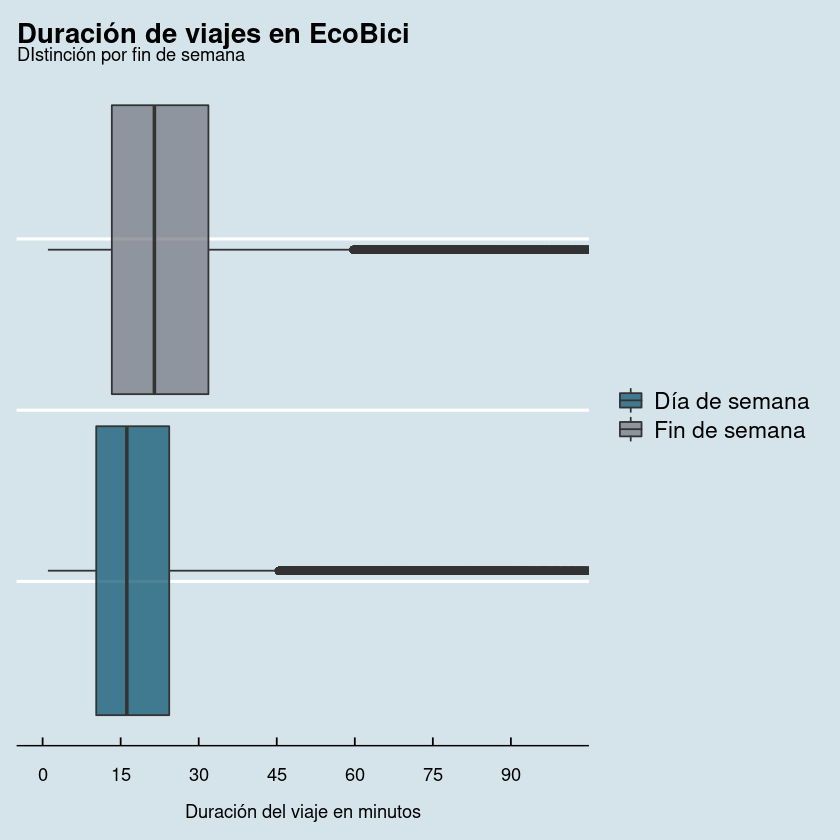

In [6]:
ggplot(ecoBiciData, 
       aes(x = duracion_recorrido_min, fill = fin_de_semana), ..scaled..) +
       geom_boxplot(alpha = 0.7) +
       coord_cartesian(xlim = c(0, 100)) +
       labs(title = "Duración de viajes en EcoBici",
            subtitle = "DIstinción por fin de semana",
            x = "\nDuración del viaje en minutos") +
       scale_fill_manual(values = c("#004c69","#72737e")) +
       theme_economist() +
       scale_x_continuous(breaks = seq(0,100,15)) +
       theme(legend.position = "right",
             legend.title = element_blank(),
             axis.ticks.y = element_blank(),
             axis.text.y = element_blank())

Veamos ahora las veinte estaciones con mayor número de extracciones durante este año.

Selecting by total


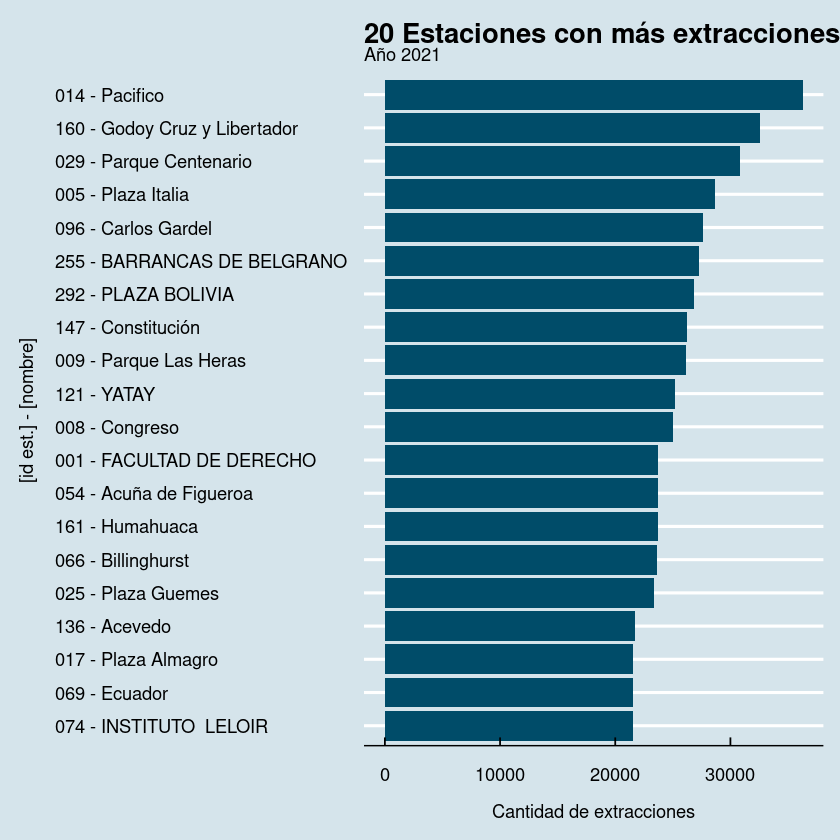

In [7]:
ecoBiciData %>% group_by(nombre_estacion_origen) %>% summarise(total = n()) %>% 
  arrange(desc(total)) %>% top_n(20) %>% 
  ggplot(aes(x = total, y = reorder(nombre_estacion_origen, total))) +
  geom_bar(stat = "identity", fill = "#004c69") +
  theme_economist() +
  labs(title = "20 Estaciones con más extracciones", 
       subtitle = "Año 2021",
       y = "[id est.] - [nombre]\n",
       x = "\nCantidad de extracciones") 

En julio se incorporaron al servicio las __[bicicletas FIT](https://mobile.twitter.com/baecobici/status/1422658373355442176)__. Estas son rodado 24, requieren menos esfuerzo al pedalear y son ajustables a la fisionomía de los usuarios. Veamos como fue la evolución desde su lanzamiento. Los picos del gráfico, como se podrá intuir, corresponden a la gran diferencia que hay en el uso del servicio condicional a si es un día laboral o no.

`summarise()` has grouped output by 'fecha'. You can override using the
`.groups` argument.


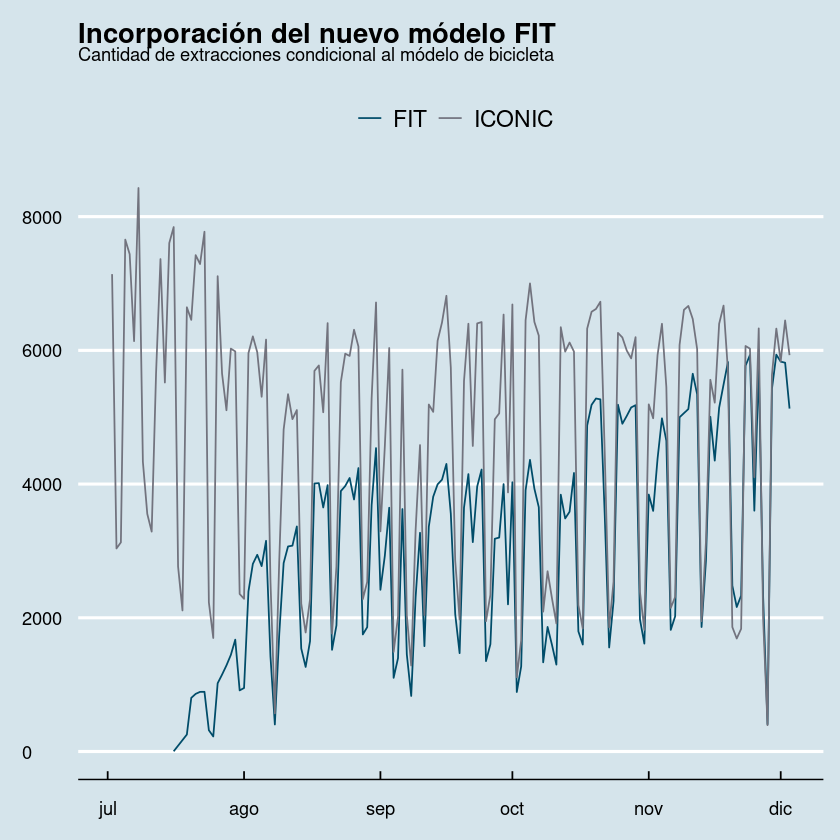

In [8]:
ecoBiciData %>% filter(fecha > as.Date("2021-07-01")) %>% 
  group_by(fecha, modelo_bicicleta) %>% summarise(total = n()) %>% 
  ggplot(aes(x = fecha, y = total, colour = modelo_bicicleta)) +
  geom_line() +
  scale_color_manual(values = c("#004c69","#72737e")) +
  labs(title = "Incorporación del nuevo módelo FIT", 
       subtitle = "Cantidad de extracciones condicional al módelo de bicicleta\n",
       y = element_blank(),
       x = element_blank()) +
  theme_economist() +
  theme(legend.title = element_blank())